Analyzing MOR/KOR data

MOR and KOR labeled animals were administered with morphine. KOR+ cells will be treated as negative control.

In [1]:
import os
import numpy as np
import pandas as pd
import shutil
from read_roi import read_roi_file
import tifffile
import matplotlib.pyplot as plt
import create_mask_for_region
from datetime import datetime
from contour_visualization import *

#import shap
# read heatmap plots
#import Heatmap_plots as hmp
import seaborn as sns
import pickle
import tifffile as tiff

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

In [2]:
# set figure key
figure_key = 'Figure8'

In [ ]:
# set paths
result_paths = r"\\10.158.246.229\DataCommon\SmartSPIM2\Ken\OPTRAP"
rootpath = r"\\10.159.50.7\LabCommon\Ken\data\MORKOR"
metapath = os.path.join(rootpath,"meta")
analysis_resultpath = os.path.join(rootpath,"result")
analysis_figurepath = os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\figure",figure_key)
for path in [analysis_resultpath,analysis_figurepath]:
    if not os.path.exists(path):
        os.mkdir(path)

# load meta info of the files
metadf = pd.read_csv(os.path.join(metapath,"MORKOR_Opioid.csv"),index_col= False)
metadf = metadf[metadf.Usable]
# load brain atlas to register
atlas_df = pd.read_csv(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\atlas_info_KimRef_FPbasedLabel_v4.0_brain_with_size_with_curated_with_cleaned_acronyms.csv",index_col = False)
metacolumns = ['id','acronym','parent_acronym','parent_id','structure_order']
contour_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v2.9_contour_map.tif")
# retrieve list of files
fnames =  [f for f in metadf.fname.values if 'DONE' in f]
# get all the leaf nodes
leafnodes = np.setdiff1d(atlas_df.acronym.unique(),atlas_df.parent_acronym.unique())

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from adjustText import adjust_text

# Set matplotlib parameters for white text on transparent background
plt.rcParams.update({
    'figure.facecolor': 'none',  # Transparent figure background
    'axes.facecolor': 'none',    # Transparent axes background
    'axes.edgecolor': 'black',   # White axes edge color
    'axes.labelcolor': 'black',  # White axis labels
    'xtick.color': 'black',      # White tick labels
    'ytick.color': 'black',      # White tick labels
    'legend.facecolor': 'none',  # Transparent legend background
    'legend.edgecolor': 'none',  # Transparent legend edgecolor
    'text.color': 'black',       # White text color
    'font.family':'Arial',
    'pdf.fonttype':42,
    'ps.fonttype':42,
   
})
#important for text to be detected when importing saved figures into illustrator


In [129]:
# Read the condition information
Conditions = metadf.Condition.unique()
print(Conditions)
Conditions = ['Acute_Morphine', ]
genotypes = metadf.Genotype.unique()
print(genotypes)
genotypes = ['KOR-Cre','MOR-Cre',]
# String for 'AcuteMOR' but MOR as superscript
genotype_names = [r"Acute$^{KOR}$",r"Acute$^{MOR}$",] # kor being a negative control
genotype_colors = ['gray','orange']

genotypes_names = ['AcuteKOR','AcuteMOR',]
raw_signal_names = ['Ex_561_Ch1_stitched','Ex_639_Ch2_stitched']
func_signal_names = ['tdTomato','c-Fos']

plotting_variables = ['Ex_561_Ch1_stitched_newcounts','Ex_561_Ch1_stitched_density',
       'Ex_639_Ch2_stitched_newcounts', 'Ex_639_Ch2_stitched_density',
       'overlap_strict_newcounts', 'overlap_strict_density',
       'overlap_over_Ex_561_Ch1_stitched', 'overlap_over_Ex_639_Ch2_stitched','F1_Score']

['Acute_Morphine']
['KOR-Cre' 'MOR-Cre']


remove HB and CBL from the list of ancestores

In [130]:
# Update the ancestor curated acronyms so it matches the tree devisions
unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB',]


remove CBL and MB subtree from the atlas file and the merge_df

In [131]:
ancestor_colors = ['#32FF00','#92278F','#F7941D','#00AEEF','#BE1E2D','#73E0FF','#00A79D','#2B3990','#637300']
root_node_color_dict = {}
for cidx,node_label in enumerate(['CTXsp', 'HPF', 'HY', 'Isocortex', 'MB', 'OLF', 'PAL', 'STR', 'TH']):
    root_node_color_dict[node_label] = ancestor_colors[cidx]

# update the ancestor_acronym in atlas_df
for ancestor_acronym in ['CTXsp', 'HPF', 'HY', 'Isocortex', 'MB', 'OLF', 'PAL', 'STR', 'TH']:
    print(ancestor_acronym)
    sub_tree = create_mask_for_region.get_subregions(atlas_df,atlas_df.loc[atlas_df.acronym == ancestor_acronym,'id'].values[0],return_original = True)
    atlas_df.loc[atlas_df.acronym.isin(sub_tree['acronym']),'ancestor_default_acronym'] = ancestor_acronym

CTXsp
HPF
HY
Isocortex
MB
OLF
PAL
STR
TH


# Preparation

## Prepare by region data

In [132]:
# all the by region data are stored in one master dataframe
total_df = pd.read_csv(os.path.join(analysis_resultpath,'total_long_merge_Annotated_counts_with_leaf_with_density.csv'),index_col = False)
total_df = total_df[total_df.Condition.isin(Conditions)]


FileNotFoundError: [Errno 2] No such file or directory: 'G:\\My Drive\\Opioid_whole_brain_manuscript\\figure\\result\\total_long_merge_Annotated_counts_with_leaf_with_density.csv'

In [41]:
# remove CBL and MB subtree from the data. These regions had bad registration quality and low interest
remove_ancestor_ids = atlas_df[(atlas_df.acronym == 'HB') | (atlas_df.acronym == 'CBL')]['id'].values
remove_df = pd.concat([create_mask_for_region.get_subregions(atlas_df,idx,return_original = True) for idx in remove_ancestor_ids],axis = 0)
sub_atlas_df = atlas_df.set_index(['id']).drop(remove_df['id'].values)
total_df = total_df[total_df.acronym.isin(sub_atlas_df.acronym.unique())]


In [42]:
# subset the merge dataframe
plotting_values = 'Ex_561_Ch1_stitched_newcounts' # this is the value that will be plotted
# sum the overlap_newcounts for the entire brain
tmerge_df = total_df.loc[(total_df.parent_acronym == 'grey'),['Genotype','ID',plotting_values]].groupby(['Genotype','ID']).sum().reset_index(drop = False)
tmerge_df= tmerge_df[tmerge_df[plotting_values]> 0] # remove the zero values that are the wrong combination of condition and ID

In [43]:
tmerge_df.groupby('Genotype').describe()

Ex_561_Ch1_stitched_newcounts                               \
                                 count          mean            std   
Genotype                                                              
KOR-Cre                            5.0  2.108352e+06  655369.047038   
MOR-Cre                            7.0  3.807458e+06  976600.951846   

                                                                 
                min        25%        50%        75%        max  
Genotype                                                         
KOR-Cre   1195719.0  1879674.0  2215271.0  2247115.0  3003983.0  
MOR-Cre   1878756.0  3802669.5  3917620.0  4039218.5  5172056.0

In [44]:
# zscore the results
normalize_key = False
plotting_values = 'overlap_over_Ex_561_Ch1_stitched'

# read the result file
pivot_heatmap_df = pd.read_csv(os.path.join(analysis_resultpath,f'{plotting_values}_pivoted_heatmap_df_without_zscore.csv'),index_col = 0)

# Load the acronyms for plottin
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)


## Prepare heatmap

In [45]:
import dask.array as da
channel = 'overlap_strict'
heatmap_da = da.from_zarr(os.path.join(analysis_resultpath, f'{channel}_heatmap_array'))
tdTchannel = 'Ex_561_Ch1_stitched'
tdT_heatmap_da = da.from_zarr(os.path.join(analysis_resultpath, f'{tdTchannel}_heatmap_array'))


In [46]:
# write the fnamelistas a pickle file
with open(os.path.join(analysis_resultpath,f'{channel}_fnamelist.pickle'), 'rb') as handle:
    fnamelist = pickle.load(handle,)

In [47]:
# read an annotated atlas file
atlas_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\LSMS\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v4.0.tif")

In [48]:
metadf = metadf.set_index('fname').loc[fnamelist,:]

In [49]:
# average the heatmaps based on the genotype
genotype1 = genotypes[0]
genotype2 = genotypes[1]
genotype1_mean_heatmap = heatmap_da[metadf.Genotype == genotype1,:].mean(axis= 0).reshape(atlas_img.shape).compute()
genotype2_mean_heatmap = heatmap_da[metadf.Genotype == genotype2,:].mean(axis= 0).reshape(atlas_img.shape).compute()

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\dask\_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\dask\_task_spec.py:745: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [50]:
# average the heatmaps based on the genotype
genotype1_mean_tdT_heatmap = tdT_heatmap_da[metadf.Genotype == genotype1,:].mean(axis= 0).reshape(atlas_img.shape).compute()
genotype2_mean_tdT_heatmap = tdT_heatmap_da[metadf.Genotype == genotype2,:].mean(axis= 0).reshape(atlas_img.shape).compute()

In [51]:
normalized_heatmap_da = heatmap_da/tdT_heatmap_da
# average the heatmaps based on the genotype
genotype1_mean_normalized_heatmap = normalized_heatmap_da[metadf.Genotype == genotype1,:].mean(axis= 0).reshape(atlas_img.shape).compute()
genotype2_mean_normalized_heatmap = normalized_heatmap_da[metadf.Genotype == genotype2,:].mean(axis= 0).reshape(atlas_img.shape).compute()

# set nan to zero
genotype1_mean_normalized_heatmap[np.isnan(genotype1_mean_normalized_heatmap)] = 0
genotype2_mean_normalized_heatmap[np.isnan(genotype2_mean_normalized_heatmap)] = 0

## Read results from WT-Opioid data

Brain regions that respond to acute morphine are selected from analysis in Figure 3

In [52]:
# read the results from the treeFDR f
TreeFDRF_df = pd.read_csv(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\result",f'TreeFDRF_pvalue_Figure2_C_glm_stat_df_no_batch.csv'),index_col = False)
# add the cleaned acronym names to the TreeFDR dataframe
TreeFDRF_df = TreeFDRF_df.merge(atlas_df[['acronym','cleaned_acronym']],left_on = 'acronym',right_on = 'acronym')
# read the effect_size_df that contains stats and pvalues
effect_size_df = pd.read_csv(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\result",f'Figure3_effect_size_df.csv'),index_col = 'acronym')
# get the rejected acronyms and print
acute_rejected_acronyms = effect_size_df[effect_size_df.Saline_vs_Acute_Morphine_qvalue < 0.05].index.values
print(len(acute_rejected_acronyms), ' rejected acronyms')
acute_rejected_acronyms


34  rejected acronyms


array(['4Sh', 'A24a (IL)', 'A25 (DP)', 'A32 (PrL)', 'AO', 'AcbC', 'AcbSh',
       'AuV', 'CLi', 'CM', 'CPc', 'Ce', 'Cl', 'DR', 'Ect', 'FrA', 'IAD',
       'IMD', 'LS', 'La', 'M2', 'MD', 'O', 'PC', 'PRh', 'PVT', 'PoMn',
       'Rh', 'S2', 'SPTg', 'ST', 'STr', 'TeA ', 'VTA'], dtype=object)

# Figure E

In [19]:
pannel_key = 'E'

Plot the double+ cell density normalized by the total number of receptor+ cells in the region

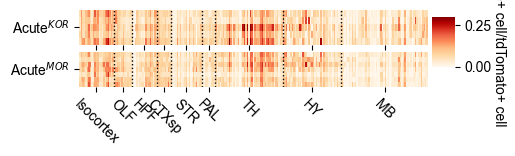

In [20]:
vmax = 0.3
vmin = 0
plotting_variable = 'overlap_over_Ex_561_Ch1_stitched'
# read the result file
pivot_heatmap_df = pd.read_csv(os.path.join(analysis_resultpath,f'{plotting_variable}_pivoted_heatmap_df_without_zscore.csv'),index_col = 0)
total_df = pd.read_csv(os.path.join(analysis_resultpath,'total_long_merge_Annotated_counts_with_leaf_with_density.csv'),index_col = False)
# Create a subset version of the ancestor_curated_acronyms
subset_ancestor_curated_acronyms = [ancestor_curated_acronyms[idx] for idx,f in enumerate(curated_acronyms)]

# Plot the heatmap
fig,axs = plt.subplots(len(genotypes),1, figsize = (4.5,len(genotypes)*0.5),sharex = True)

# calculate variables to plot the heatmatp
__,indexes = np.unique(subset_ancestor_curated_acronyms, return_index=True,)
ytick_labels = [subset_ancestor_curated_acronyms[index] for index in sorted(indexes)]
counts = [len(np.where(np.array(subset_ancestor_curated_acronyms) == ylabel)[0]) for ylabel in ytick_labels]

borders = [0] + list(np.cumsum(counts))

x = np.array(borders)
yticks = (x[1:] + x[:-1]) / 2

for idx,genotype in enumerate(genotypes):
    subjects = metadf[(metadf.Genotype == genotype)].ID.values
    if idx == len(genotypes)-1:
        cbar_ax = fig.add_axes([axs[len(genotypes)-1].get_position().x1+0.01,axs[len(genotypes)-1].get_position().y0+0.2,0.05,0.5])
        sns.heatmap(data = pivot_heatmap_df.loc[curated_acronyms,subjects].T,cbar_ax = cbar_ax
        ,ax = axs[idx],vmin = vmin, vmax = vmax,cmap = 'OrRd')
        cbar_ax.set_ylabel('double+ cell/tdTomato+ cell', rotation=270, labelpad=10, fontsize=10)  # Updated ylabel text
        
        
    else:
        sns.heatmap(data = pivot_heatmap_df.loc[curated_acronyms,subjects].T,cbar = False
        ,ax = axs[idx],vmin = vmin, vmax = vmax,cmap = 'OrRd')
    axs[idx].set_xticks(yticks)
    axs[idx].set_xticklabels(ytick_labels,rotation = -45)
    axs[idx].set_xlabel('')
    [axs[idx].axvline(border,color = 'black',lw = 1,ls = ':') for border in borders[1:-1]]
    axs[idx].set_yticks([pivot_heatmap_df.loc[curated_acronyms,subjects].T.shape[0]//2+0.5])
    #axs[idx].set_yticklabels([],rotation = 0) 
    axs[idx].set_yticklabels([genotype_names[idx]],rotation = 0)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)


# Figure C

In [21]:
import numpy as np

def set_transparency(rgba_img, mask):
    """
    Applies a transparency mask to an existing RGBA image.

    Parameters:
    - rgba_img: np.ndarray of shape (H, W, 4), dtype uint8
        The input RGBA image.
    - mask: np.ndarray of shape (H, W), dtype bool
        Boolean mask where True means the pixel should be transparent.

    Returns:
    - np.ndarray of shape (H, W, 4), modified RGBA image.
    """
    if rgba_img.shape[-1] != 4:
        raise ValueError("Input image must be RGBA (shape must be H x W x 4).")
    if rgba_img.shape[:2] != mask.shape:
        raise ValueError("Mask shape must match image height and width.")

    # Copy to avoid modifying the original
    result = rgba_img.copy()
    result[mask, 3] = 0  # Set alpha to 0 (transparent) where mask is True
    return result


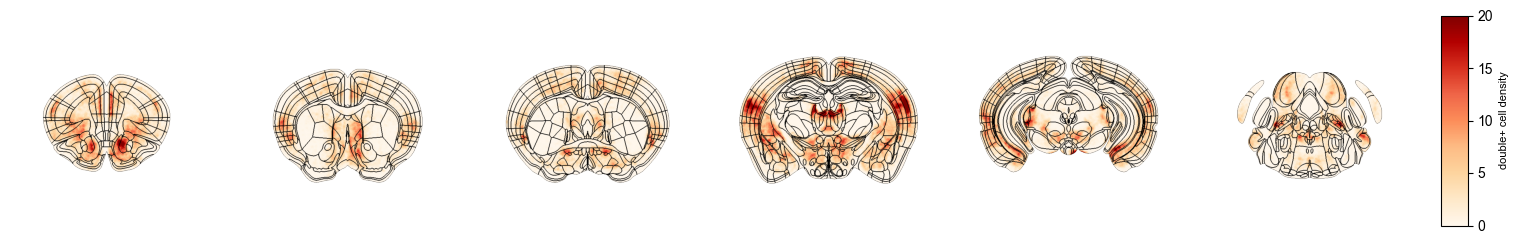

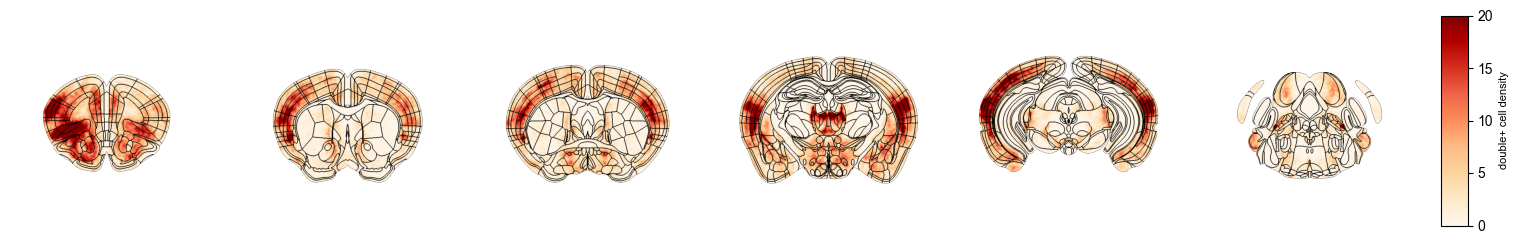

In [77]:
import matplotlib as mpl
# set vmax
vmax = 20
# pre selected zplanes
curated_zplanes = [84,104,117,153,186,220]
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)
channel = 'overlap_strict'
# plot every 10 zplanes
for genotype in genotypes:
    theatmap = tifffile.imread(os.path.join(analysis_resultpath,f'{genotype}_{channel}_mean_heatmap.tif'))
    fig,axs = plt.subplots(1,len(curated_zplanes),figsize = (3*len(curated_zplanes),3),sharey = True)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    for idx,ax in enumerate(axs):
        formatted_idx = f"{curated_zplanes[idx]:04}" 
        
        image_slice = theatmap[curated_zplanes[idx],imy_slice,imx_slice]
        contour_slice = contour_img[curated_zplanes[idx],imy_slice,imx_slice]
        __,overlayed_image = overlap_contour(image_slice,contour_slice,\
        cmin =  0, cmax = vmax,\
        colormap = plt.cm.OrRd,)
        trans_img = set_transparency(overlayed_image[:,:], (atlas_img==0)[curated_zplanes[idx],imy_slice,imx_slice])
        ax.imshow(trans_img)
        ax.axis('off')
        ax.set_title('')
        ax.set_ylabel(genotype,color = 'black')
    # Add a colorbar next to the last subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.OrRd, norm=norm)
    cbar.set_label('double+ cell density', fontsize=8)


    # save the plot
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{genotype}.png'),bbox_inches = 'tight',dpi = 216)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{genotype}.pdf'),bbox_inches = 'tight',dpi = 216)


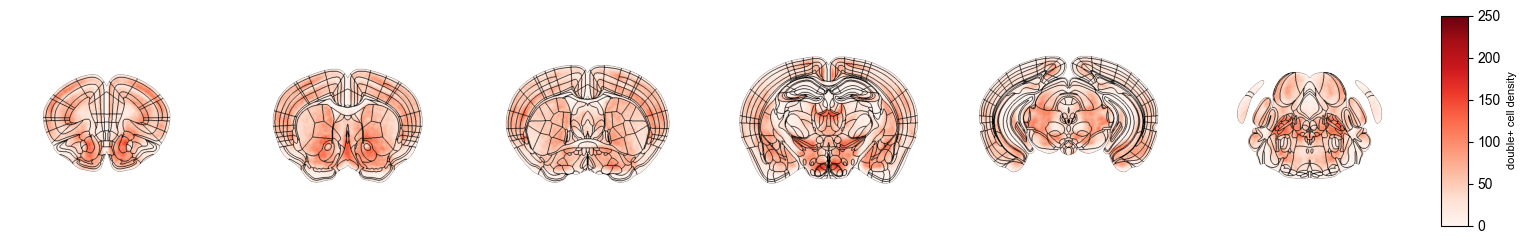

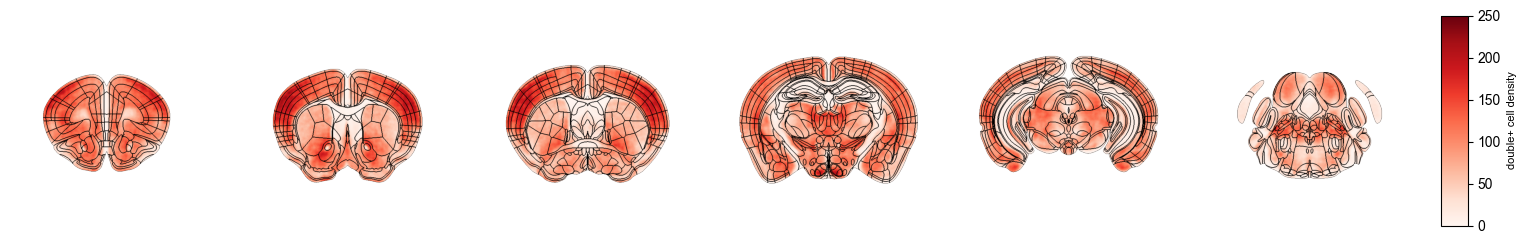

In [30]:
import matplotlib as mpl
# set vmax
vmax = 250
# pre selected zplanes
curated_zplanes = [84,104,117,153,186,220]
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)
channel = 'Ex_561_Ch1_stitched'
# plot every 10 zplanes
for genotype in genotypes:
    theatmap = tifffile.imread(os.path.join(analysis_resultpath,f'{genotype}_{channel}_mean_heatmap.tif'))
    fig,axs = plt.subplots(1,len(curated_zplanes),figsize = (3*len(curated_zplanes),3),sharey = True)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    for idx,ax in enumerate(axs):
        formatted_idx = f"{curated_zplanes[idx]:04}" 
        
        image_slice = theatmap[curated_zplanes[idx],imy_slice,imx_slice]
        contour_slice = contour_img[curated_zplanes[idx],imy_slice,imx_slice]
        __,overlayed_image = overlap_contour(image_slice,contour_slice,\
        cmin =  0, cmax = vmax,\
        colormap = plt.cm.Reds,)
        trans_img = set_transparency(overlayed_image[:,:], (atlas_img==0)[curated_zplanes[idx],imy_slice,imx_slice])
        ax.imshow(trans_img)
        ax.axis('off')
        ax.set_title('')
        ax.set_ylabel(genotype,color = 'black')
    # Add a colorbar next to the last subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.Reds, norm=norm)
    cbar.set_label('double+ cell density', fontsize=8)


    # save the plot
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{genotype}_{channel}.png'),bbox_inches = 'tight',dpi = 216)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{genotype}_{channel}.pdf'),bbox_inches = 'tight',dpi = 216)


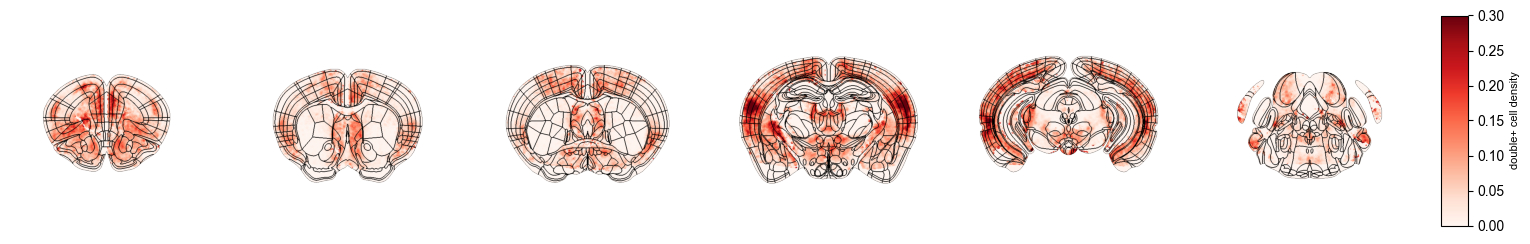

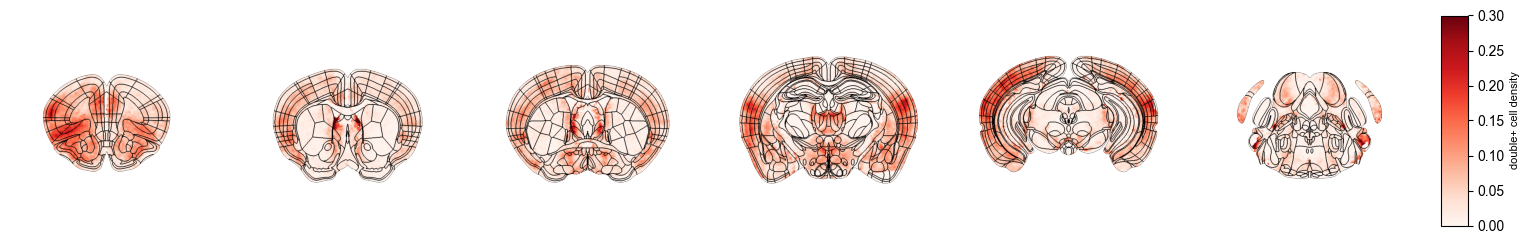

In [22]:
import matplotlib as mpl
# set vmax
vmax = 0.3
# pre selected zplanes
curated_zplanes = [84,104,117,153,186,220]
# slice for visualization
imy_slice = slice(25,425)
imx_slice = slice(50,600)
channel = 'normalized_overlap_strict'
# plot every 10 zplanes
for gidx,genotype in enumerate(genotypes):
    #theatmap = tifffile.imread(os.path.join(analysis_resultpath,f'{genotype}_{channel}_mean_heatmap.tif'))
    theatmap = [genotype1_mean_normalized_heatmap,genotype2_mean_normalized_heatmap][gidx]
    theatmap[np.isnan(theatmap)] = 0
    fig,axs = plt.subplots(1,len(curated_zplanes),figsize = (3*len(curated_zplanes),3),sharey = True)
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    for idx,ax in enumerate(axs):
        formatted_idx = f"{curated_zplanes[idx]:04}" 
        
        image_slice = theatmap[curated_zplanes[idx],imy_slice,imx_slice]
        contour_slice = contour_img[curated_zplanes[idx],imy_slice,imx_slice]
        __,overlayed_image = overlap_contour(image_slice,contour_slice,\
        cmin =  0, cmax = vmax,\
        colormap = plt.cm.Reds,)
        trans_img = set_transparency(overlayed_image[:,:], (atlas_img==0)[curated_zplanes[idx],imy_slice,imx_slice])
        ax.imshow(trans_img)
        ax.axis('off')
        ax.set_title('')
        ax.set_ylabel(genotype,color = 'black')
    # Add a colorbar next to the last subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=plt.cm.Reds, norm=norm)
    cbar.set_label('double+ cell density', fontsize=8)


    # save the plot
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{genotype}_{channel}.png'),bbox_inches = 'tight',dpi = 216)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{genotype}_{channel}.pdf'),bbox_inches = 'tight',dpi = 216)


# Figure G

In [104]:
pannel_key = 'G'

In [105]:
from scipy.stats import ttest_ind

genotype1 = 'MOR-Cre'
genotype2 = 'KOR-Cre'
variable = 'overlap_over_Ex_561_Ch1_stitched'
for acronym in total_df.acronym.unique():
    genotype1_array = total_df[(total_df.Genotype == genotype1) & (total_df.acronym == acronym)][variable].values.astype('float')
    genotype2_array = total_df[(total_df.Genotype == genotype2) & (total_df.acronym == acronym)][variable].values.astype('float')
    s_,p_ = ttest_ind(genotype1_array, genotype2_array)
    if np.isnan(p_):
        p_ = 1
    effect_size_df.loc[acronym,f'{genotype1}_vs_{genotype2}_pvalue'] = p_
    effect_size_df.loc[acronym,f'{genotype1}_vs_{genotype2}_delta'] = np.mean(genotype1_array) - np.mean(genotype2_array)

In [341]:
from statsmodels.stats import multitest
ps = effect_size_df.loc[acute_rejected_acronyms,'MOR-Cre_vs_KOR-Cre_pvalue'].values
stats,qvalues,__,__ = multitest.multipletests(ps,alpha = 0.05,method = 'fdr_bh')

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_17532\2341112784.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([atlas_df[atlas_df.acronym == f].cleaned_acronym.values[0] for f in sorted_acronyms_list],fontsize = 11,rotation = -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PC_KOR-Cre vs. PC_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:2.366e-01 t=1.259e+00
STr_KOR-Cre vs. STr_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:2.304e-01 t=1.277e+00
SPTg_KOR-Cre vs. SPTg_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:2.552e-01 t=1.207e+00
4Sh_KOR-Cre vs. 4Sh_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:2.553e-01 t=1.207e+00
AcbSh_KOR-Cre vs. AcbSh_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:3.013e-01 t=1.090e+00
A32 (PrL)_KOR-Cre vs. A32 (PrL)_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:3.269e-01 t=1.031e+00
CM_KOR-Cre vs. CM_MOR-Cre: t-test independent samples with Benjamini-Hoc

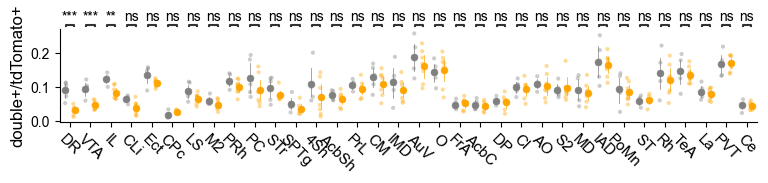

In [342]:
variable = 'overlap_over_Ex_561_Ch1_stitched'
genotype1,genotype2 = 'KOR-Cre','MOR-Cre'
#variable = 'overlap_strict_density'
sorted_acronyms_list = acute_rejected_acronyms[np.argsort(qvalues)]
fig,axs = plt.subplots(1,1,figsize = (9,1.2))

sns.stripplot(data = total_df[total_df.acronym.isin(acute_rejected_acronyms)],
            hue = 'Genotype',y = variable,x = 'acronym',dodge = True,
            order = sorted_acronyms_list,\
            hue_order = genotypes,ax = axs,\
            palette = genotype_colors,alpha = 0.4,size = 3)
sns.pointplot(total_df[total_df.acronym.isin(acute_rejected_acronyms)],
            hue = 'Genotype',y = variable,x = 'acronym',order = sorted_acronyms_list,
            dodge = .5-.5/len(acute_rejected_acronyms),\
        hue_order = genotypes,ax = axs,palette = genotype_colors,
markers="o", markersize=5, linestyle="none",linewidth = 0.5)  
sns.despine()
axs.set_xticklabels([atlas_df[atlas_df.acronym == f].cleaned_acronym.values[0] for f in sorted_acronyms_list],fontsize = 11,rotation = -45)
# remove legend
axs.get_legend().remove()
axs.set_xlabel('')
axs.set_ylabel('double+/tdTomato+',fontsize = 12)
# add a horizontal line to separate the clusters
#borders = [0] + list(np.cumsum(nregions_list))
#[axs.axvline(border - 0.5,color = 'gray',lw = 2,ls = ':') for border in borders[1:-1]]


from statannotations.Annotator import Annotator
pairs = [((c,genotype1),(c,genotype2)) for c in sorted_acronyms_list]

annotator = Annotator(axs, pairs, data = total_df[total_df.acronym.isin(acute_rejected_acronyms)],
            hue = 'Genotype',y = variable,x = 'acronym',
            order = sorted_acronyms_list)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()


fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)


In [343]:
pannel_key = 'G_tdT'

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_17532\2119914175.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels([atlas_df[atlas_df.acronym == f].cleaned_acronym.values[0] for f in sorted_acronyms_list],fontsize = 11,rotation = -45)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PC_KOR-Cre vs. PC_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:1.850e-04 t=-5.751e+00
STr_KOR-Cre vs. STr_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:1.619e-01 t=-1.510e+00
SPTg_KOR-Cre vs. SPTg_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:1.902e-01 t=-1.405e+00
4Sh_KOR-Cre vs. 4Sh_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:4.781e-02 (ns) t=-2.255e+00
AcbSh_KOR-Cre vs. AcbSh_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:2.412e-01 t=-1.246e+00
A32 (PrL)_KOR-Cre vs. A32 (PrL)_MOR-Cre: t-test independent samples with Benjamini-Hochberg correction, P_val:5.748e-03 t=-3.498e+00
CM_KOR-Cre vs. CM_MOR-Cre: t-test independent samples with Be

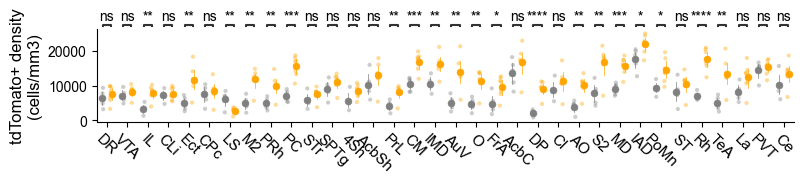

In [344]:
variable = 'Ex_561_Ch1_stitched_density'
genotype1,genotype2 = 'KOR-Cre','MOR-Cre'
#variable = 'overlap_strict_density'
sorted_acronyms_list = acute_rejected_acronyms[np.argsort(qvalues)]
fig,axs = plt.subplots(1,1,figsize = (9,1.2))

sns.stripplot(data = total_df[total_df.acronym.isin(acute_rejected_acronyms)],
            hue = 'Genotype',y = variable,x = 'acronym',dodge = True,
            order = sorted_acronyms_list,\
            hue_order = genotypes,ax = axs,\
            palette = genotype_colors,alpha = 0.4,size = 3)
sns.pointplot(total_df[total_df.acronym.isin(acute_rejected_acronyms)],
            hue = 'Genotype',y = variable,x = 'acronym',order = sorted_acronyms_list,
            dodge = .5-.5/len(acute_rejected_acronyms),\
        hue_order = genotypes,ax = axs,palette = genotype_colors,
markers="o", markersize=5, linestyle="none",linewidth = 0.5)  
sns.despine()
axs.set_xticklabels([atlas_df[atlas_df.acronym == f].cleaned_acronym.values[0] for f in sorted_acronyms_list],fontsize = 11,rotation = -45)
# remove legend
axs.get_legend().remove()
axs.set_xlabel('')
axs.set_ylabel('tdTomato+ density\n(cells/mm3)',fontsize = 12)
# add a horizontal line to separate the clusters
#borders = [0] + list(np.cumsum(nregions_list))
#[axs.axvline(border - 0.5,color = 'gray',lw = 2,ls = ':') for border in borders[1:-1]]


from statannotations.Annotator import Annotator
pairs = [((c,genotype1),(c,genotype2)) for c in sorted_acronyms_list]

annotator = Annotator(axs, pairs, data = total_df[total_df.acronym.isin(acute_rejected_acronyms)],
            hue = 'Genotype',y = variable,x = 'acronym',
            order = sorted_acronyms_list)
annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
annotator.configure(comparisons_correction="BH", correction_format="replace")
annotator.apply_and_annotate()


fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)


# Figure 8: spatial analysis of DR

In [127]:
import create_mask_for_region

In [128]:
atlas_df = pd.read_csv(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\atlas_info_KimRef_FPbasedLabel_v4.0_brain_with_size_with_curated_with_cleaned_acronyms.csv",index_col = False)

conduct analysis of DR distribution

In [129]:
# target site can be experiment specific
target_site_acronym = 'DR'
target_site_id = atlas_df.loc[atlas_df.acronym == target_site_acronym,'id'].values[0]
target_site_subids = create_mask_for_region.get_subregions(atlas_df,target_site_id,return_original=True)['id'].values
target_site_subacronyms = create_mask_for_region.get_subregions(atlas_df,target_site_id,return_original=True)['acronym'].values
print(target_site_subacronyms)

['DR_leaf' 'DRC' 'DRD' 'DRI' 'DRL' 'DRV' 'PDR' 'DR']


In [130]:
# collect all the z positions where there is the target site
zs = np.array([])
for ID in target_site_subids:
    z_,y_,x_ = np.where(atlas_img == ID)
    zs = np.concatenate([zs,z_])
# find the center of mass of the VTA
z_unique = np.unique(zs).astype('uint16')
z_center = int(np.mean(zs))

In [131]:
# calculate the spatial distribution of c-Fos+ cells for each subject
'''spatial_cell_count_for_subregion = np.array([[[np.nanmean(subset_heatmap[z,np.where(atlas_img[z,:,:] == target_site_subid)[0],\
                                                                         np.where(atlas_img[z,:,:] == target_site_subid)[1]]) for z in z_unique]\
                                                                              for target_site_subid in target_site_subids] \
                                                                                for subset_heatmap in [genotype1_mean_heatmap,genotype2_mean_heatmap]])
'''
spatial_cell_count_for_subregion = np.array([[[np.nanmean(subset_heatmap[z,np.where(atlas_img[z,:,:] == target_site_subid)[0],\
                                                                         np.where(atlas_img[z,:,:] == target_site_subid)[1]]) for z in z_unique]\
                                                                              for target_site_subid in target_site_subids] \
                                                                                for subset_heatmap in [genotype1_mean_normalized_heatmap,genotype2_mean_normalized_heatmap]])


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_40128\4127320118.py:7: RuntimeWarning: Mean of empty slice
  spatial_cell_count_for_subregion = np.array([[[np.nanmean(subset_heatmap[z,np.where(atlas_img[z,:,:] == target_site_subid)[0],\


In [132]:
# calculate cell count for full region
spatial_cell_count_for_full = np.nansum(spatial_cell_count_for_subregion,axis = 1)

In [133]:
np.save(os.path.join(analysis_resultpath,f'spatial_factors_for_subregion_sum_{target_site_acronym}.npy'),spatial_cell_count_for_full,)
np.save(os.path.join(analysis_resultpath,f'spatial_factors_for_subregion_{target_site_acronym}.npy'),spatial_cell_count_for_subregion,)

In [134]:
# split the Acumbens into anterior middle posterior
z_anterior,z_medial,z_posterior = np.array_split(z_unique, 3)

In [135]:
# subset to NAc region
imx_slice = slice(265,265+120)
imy_slice = slice(135,135+120)

In [136]:
pannel_key = 'H'

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


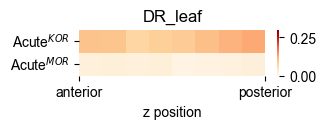

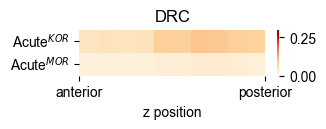

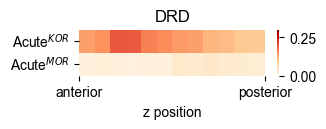

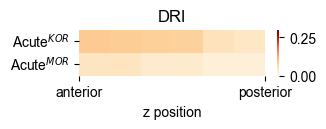

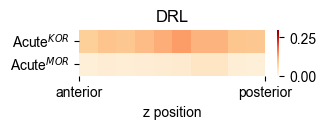

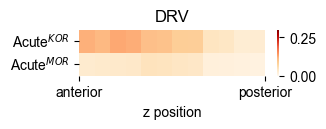

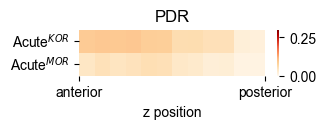

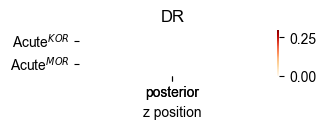

In [137]:
for  idx,sub_acronym in enumerate(target_site_subacronyms):
    genotype_orders = [np.where(np.array([genotype1,genotype2]) == f)[0][0] for f in genotypes]
    #tarray = spatial_cell_count_for_subregion[rejected_factor_idx,idx,:]
    tarray = spatial_cell_count_for_subregion[genotype_orders,idx,:]
    tarray = tarray[:,~np.isnan(tarray[0,:])]


    fig,axs = plt.subplots(1,1,figsize = (3,0.6))
    sns.heatmap(tarray,ax = axs,cmap = 'OrRd',vmin = 0,vmax= 0.3)
    axs.set_title(sub_acronym)
    axs.set_yticks(np.array(range(len(genotype_orders))) + 0.5)
    axs.set_yticklabels(genotype_names,rotation = 0)
    axs.set_xticks([0,tarray.shape[1]])
    axs.set_xticklabels(['anterior','posterior'])    
    
    axs.set_xlabel('z position')
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{sub_acronym}.png'),bbox_inches='tight',dpi = 512)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{sub_acronym}.pdf'),bbox_inches='tight',dpi = 512)



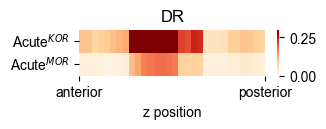

In [138]:
genotype_orders = [np.where(np.array([genotype1,genotype2]) == f)[0][0] for f in genotypes]
#tarray = spatial_cell_count_for_subregion[rejected_factor_idx,idx,:]
tarray = spatial_cell_count_for_full[genotype_orders,:]
tarray = tarray[:,~np.isnan(tarray[0,:])]


fig,axs = plt.subplots(1,1,figsize = (3,0.6))
sns.heatmap(tarray,ax = axs,cmap = 'OrRd',vmin = 0,vmax= 0.3)
axs.set_title(sub_acronym)
axs.set_yticks(np.array(range(len(genotype_orders))) + 0.5)
axs.set_yticklabels(genotype_names,rotation = 0)
axs.set_xticks([0,tarray.shape[1]])
axs.set_xticklabels(['anterior','posterior'])    

axs.set_xlabel('z position')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 512)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.svg'),bbox_inches='tight',dpi = 512)



In [139]:
pannel_key = 'I'

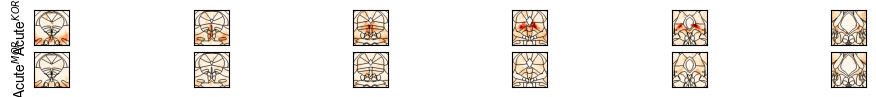

In [140]:
# plot the spatial distribution of cells using betacoef
#channel_key = 'overlap'
vmax = 0.3
channel_key = 'normalized_overlap_strict'
fig, axs = plt.subplots(len(genotypes), len(z_unique[::5]), 
                        figsize=(len(z_unique[::5])*2, len(Conditions)), sharex=True,sharey = True)

for cidx, genotype in enumerate(genotypes):
    #theatmap = np.load(os.path.join(analysis_resultpath,f'{channel_key}_{condition}_betas.npy'))
    #theatmap = tifffile.imread(os.path.join(analysis_resultpath,f'{genotype}_{channel}_mean_heatmap.tif'))
    theatmap = [genotype1_mean_normalized_heatmap,genotype2_mean_normalized_heatmap][cidx]

    for idx, curated_zplane in enumerate(z_unique[::5]):
        ax = axs[cidx, idx]
        image_slice = theatmap[curated_zplane,imy_slice,imx_slice]
        contour_slice = contour_img[curated_zplane,imy_slice,imx_slice]
        __,overlayed_image = overlap_contour(image_slice,contour_slice,\
        cmin =  0, cmax = vmax,\
        colormap = plt.cm.OrRd,)
        trans_img = set_transparency(overlayed_image[:,:], (atlas_img==0)[curated_zplane,imy_slice,imx_slice])
        ax.imshow(trans_img)

        ax.set_xticks([])  # Remove x ticks
        ax.set_yticks([])  # Remove y ticks
        #ax.axis('off')
        if idx == 0:
            ax.set_ylabel(genotype_names[cidx], color='black', )
        else:
            ax.set_ylabel('', color='black',)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 1024)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 1024)

In [141]:
# calculate the spatial distribution of tdTomato+ cells for each subject
tdTomato_spatial_cell_count_for_subregion = np.array([[[np.nanmean(subset_heatmap[z,np.where(atlas_img[z,:,:] == target_site_subid)[0],\
                                                                         np.where(atlas_img[z,:,:] == target_site_subid)[1]]) for z in z_unique]\
                                                                              for target_site_subid in target_site_subids] \
                                                                                for subset_heatmap in [genotype1_mean_tdT_heatmap,genotype2_mean_tdT_heatmap]])


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_40128\1571715533.py:2: RuntimeWarning: Mean of empty slice
  tdTomato_spatial_cell_count_for_subregion = np.array([[[np.nanmean(subset_heatmap[z,np.where(atlas_img[z,:,:] == target_site_subid)[0],\


In [142]:
# calculate cell count for full region
tdTomato_spatial_cell_count_for_full = np.nansum(tdTomato_spatial_cell_count_for_subregion,axis = 1)

In [143]:
np.save(os.path.join(analysis_resultpath,f'tdTomato_spatial_factors_for_subregion_sum_{target_site_acronym}.npy'),tdTomato_spatial_cell_count_for_full,)
np.save(os.path.join(analysis_resultpath,f'tdTomato_spatial_factors_for_subregion_{target_site_acronym}.npy'),tdTomato_spatial_cell_count_for_subregion,)

In [144]:
# split the Acumbens into anterior middle posterior
z_anterior,z_medial,z_posterior = np.array_split(z_unique, 3)

In [145]:
# subset to NAc region
imx_slice = slice(265,265+120)
imy_slice = slice(135,135+120)

In [146]:
pannel_key = 'H_tdT'

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


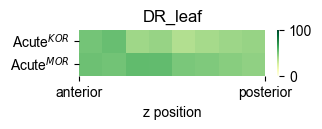

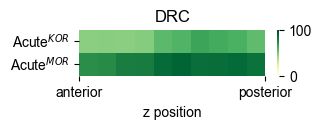

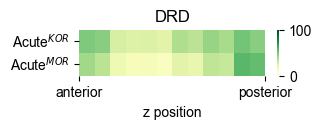

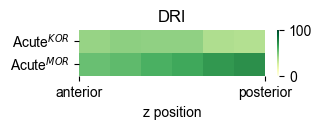

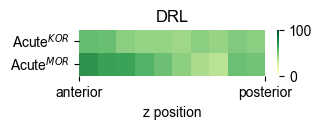

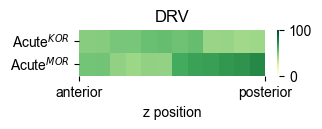

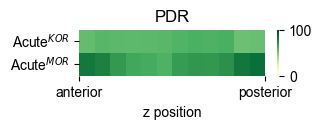

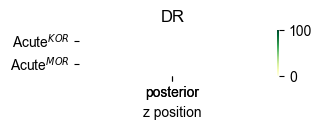

In [147]:
tdTomato_vmax = 100
for  idx,sub_acronym in enumerate(target_site_subacronyms):
    genotype_orders = [np.where(np.array([genotype1,genotype2]) == f)[0][0] for f in genotypes]
    #tarray = spatial_cell_count_for_subregion[rejected_factor_idx,idx,:]
    tarray = tdTomato_spatial_cell_count_for_subregion[genotype_orders,idx,:]
    tarray = tarray[:,~np.isnan(tarray[0,:])]


    fig,axs = plt.subplots(1,1,figsize = (3,0.6))
    sns.heatmap(tarray,ax = axs,cmap = 'YlGn',vmin = 0,vmax= tdTomato_vmax)
    axs.set_title(sub_acronym)
    axs.set_yticks(np.array(range(len(genotype_orders))) + 0.5)
    axs.set_yticklabels(genotype_names,rotation = 0)
    axs.set_xticks([0,tarray.shape[1]])
    axs.set_xticklabels(['anterior','posterior'])    
    
    axs.set_xlabel('z position')
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{sub_acronym}.png'),bbox_inches='tight',dpi = 512)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{sub_acronym}.pdf'),bbox_inches='tight',dpi = 512)



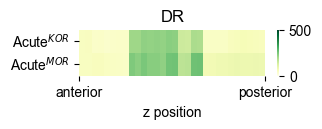

In [148]:
genotype_orders = [np.where(np.array([genotype1,genotype2]) == f)[0][0] for f in genotypes]
#tarray = spatial_cell_count_for_subregion[rejected_factor_idx,idx,:]
tarray = tdTomato_spatial_cell_count_for_full[genotype_orders,:]
tarray = tarray[:,~np.isnan(tarray[0,:])]


fig,axs = plt.subplots(1,1,figsize = (3,0.6))
sns.heatmap(tarray,ax = axs,cmap = 'YlGn',vmin = 0,vmax= tdTomato_vmax*5)
axs.set_title(sub_acronym)
axs.set_yticks(np.array(range(len(genotype_orders))) + 0.5)
axs.set_yticklabels(genotype_names,rotation = 0)
axs.set_xticks([0,tarray.shape[1]])
axs.set_xticklabels(['anterior','posterior'])    

axs.set_xlabel('z position')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 512)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 512)



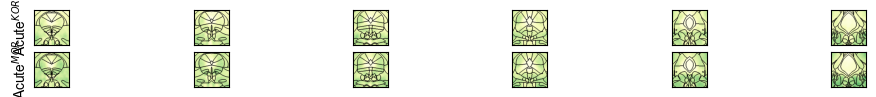

In [149]:
# plot the spatial distribution of cells using betacoef
#channel_key = 'overlap'
pannel_key = 'X_tdT'
vmax = 250
channel_key = 'Ex_561_Ch1_stitched'
fig, axs = plt.subplots(len(genotypes), len(z_unique[::5]), 
                        figsize=(len(z_unique[::5])*2, len(Conditions)), sharex=True,sharey = True)

for cidx, genotype in enumerate(genotypes):
    #theatmap = np.load(os.path.join(analysis_resultpath,f'{channel_key}_{condition}_betas.npy'))
    #theatmap = tifffile.imread(os.path.join(analysis_resultpath,f'{genotype}_{channel}_mean_heatmap.tif'))
    theatmap = [genotype1_mean_tdT_heatmap,genotype2_mean_tdT_heatmap][cidx]

    for idx, curated_zplane in enumerate(z_unique[::5]):
        ax = axs[cidx, idx]
        image_slice = theatmap[curated_zplane,imy_slice,imx_slice]
        contour_slice = contour_img[curated_zplane,imy_slice,imx_slice]
        __,overlayed_image = overlap_contour(image_slice,contour_slice,\
        cmin =  0, cmax = vmax,\
        colormap = plt.cm.YlGn,)
        trans_img = set_transparency(overlayed_image[:,:], (atlas_img==0)[curated_zplane,imy_slice,imx_slice])
        ax.imshow(trans_img)

        ax.set_xticks([])  # Remove x ticks
        ax.set_yticks([])  # Remove y ticks
        #ax.axis('off')
        if idx == 0:
            ax.set_ylabel(genotype_names[cidx], color='black', )
        else:
            ax.set_ylabel('', color='black',)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 1024)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 1024)

# Figure 8: spatial analysis of VTA

In [150]:
import create_mask_for_region

In [151]:
atlas_df = pd.read_csv(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\atlas_info_KimRef_FPbasedLabel_v4.0_brain_with_size_with_curated_with_cleaned_acronyms.csv",index_col = False)

conduct analysis of VTA distribution

In [152]:
# target site can be experiment specific
target_site_acronym = 'VTA'
target_site_id = atlas_df.loc[atlas_df.acronym == target_site_acronym,'id'].values[0]
target_site_subids = create_mask_for_region.get_subregions(atlas_df,target_site_id,return_original=True)['id'].values
target_site_subacronyms = create_mask_for_region.get_subregions(atlas_df,target_site_id,return_original=True)['acronym'].values
print(target_site_subacronyms)

['VTA_leaf' 'PN' 'PIF' 'PBP' 'VTAR' 'VTA']


In [153]:
# collect all the z positions where there is the target site
zs = np.array([])
for ID in target_site_subids:
    z_,y_,x_ = np.where(atlas_img == ID)
    zs = np.concatenate([zs,z_])
# find the center of mass of the VTA
z_unique = np.unique(zs).astype('uint16')
z_center = int(np.mean(zs))

In [154]:
# calculate the spatial distribution of c-Fos+ cells for each subject
#spatial_cell_count_for_subregion = np.array([[[np.nanmean(subset_heatmap[z,np.where(atlas_img[z,:,:] == target_site_subid)[0],np.where(atlas_img[z,:,:] == target_site_subid)[1]]) for z in z_unique] for target_site_subid in target_site_subids] for subset_heatmap in [genotype1_mean_heatmap,genotype2_mean_heatmap]])
spatial_cell_count_for_subregion = np.array([[[np.nanmean(subset_heatmap[z,np.where(atlas_img[z,:,:] == target_site_subid)[0],np.where(atlas_img[z,:,:] == target_site_subid)[1]]) for z in z_unique] for target_site_subid in target_site_subids] for subset_heatmap in [genotype1_mean_normalized_heatmap,genotype2_mean_normalized_heatmap]])



C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_40128\1742684788.py:3: RuntimeWarning: Mean of empty slice
  spatial_cell_count_for_subregion = np.array([[[np.nanmean(subset_heatmap[z,np.where(atlas_img[z,:,:] == target_site_subid)[0],np.where(atlas_img[z,:,:] == target_site_subid)[1]]) for z in z_unique] for target_site_subid in target_site_subids] for subset_heatmap in [genotype1_mean_normalized_heatmap,genotype2_mean_normalized_heatmap]])


In [155]:
# calculate cell count for full region
spatial_cell_count_for_full = np.nansum(spatial_cell_count_for_subregion,axis = 1)

In [156]:
np.save(os.path.join(analysis_resultpath,f'spatial_factors_for_subregion_sum_{target_site_acronym}.npy'),spatial_cell_count_for_full,)
np.save(os.path.join(analysis_resultpath,f'spatial_factors_for_subregion_{target_site_acronym}.npy'),spatial_cell_count_for_subregion,)

In [157]:
# split the Acumbens into anterior middle posterior
z_anterior,z_medial,z_posterior = np.array_split(z_unique, 3)

In [158]:
# subset to VTA region
imx_slice = slice(310,310+120)
imy_slice = slice(220,220+120)

In [159]:
pannel_key = 'K'

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


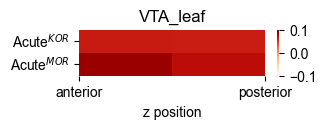

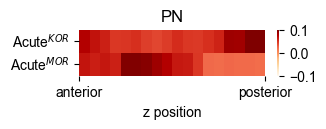

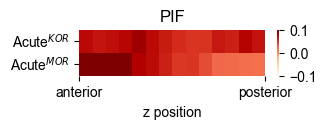

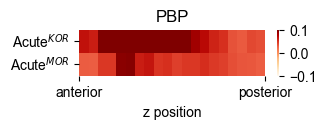

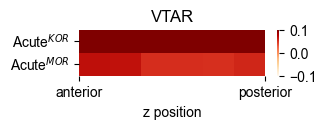

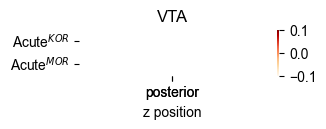

In [160]:
vmax = 0.3
for  idx,sub_acronym in enumerate(target_site_subacronyms):
    genotype_orders = [np.where(np.array([genotype1,genotype2]) == f)[0][0] for f in genotypes]
    #tarray = spatial_cell_count_for_subregion[rejected_factor_idx,idx,:]
    tarray = spatial_cell_count_for_subregion[genotype_orders,idx,:]
    tarray = tarray[:,~np.isnan(tarray[0,:])]


    fig,axs = plt.subplots(1,1,figsize = (3,0.6))
    sns.heatmap(tarray,ax = axs,cmap = 'OrRd',vmin = 0,vmax= vmax//2)
    axs.set_title(sub_acronym)
    axs.set_yticks(np.array(range(len(genotype_orders))) + 0.5)
    axs.set_yticklabels(genotype_names,rotation = 0)
    axs.set_xticks([0,tarray.shape[1]])
    axs.set_xticklabels(['anterior','posterior'])    
    
    axs.set_xlabel('z position')
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{sub_acronym}.png'),bbox_inches='tight',dpi = 512)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{sub_acronym}.pdf'),bbox_inches='tight',dpi = 512)



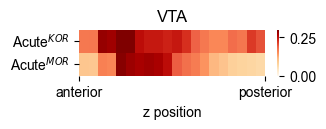

In [161]:
genotype_orders = [np.where(np.array([genotype1,genotype2]) == f)[0][0] for f in genotypes]
#tarray = spatial_cell_count_for_subregion[rejected_factor_idx,idx,:]
tarray = spatial_cell_count_for_full[genotype_orders,:]
tarray = tarray[:,~np.isnan(tarray[0,:])]


fig,axs = plt.subplots(1,1,figsize = (3,0.6))
sns.heatmap(tarray,ax = axs,cmap = 'OrRd',vmin = 0,vmax= vmax)
axs.set_title(sub_acronym)
axs.set_yticks(np.array(range(len(genotype_orders))) + 0.5)
axs.set_yticklabels(genotype_names,rotation = 0)
axs.set_xticks([0,tarray.shape[1]])
axs.set_xticklabels(['anterior','posterior'])    

axs.set_xlabel('z position')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 512)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 512)



In [162]:
pannel_key = 'J'

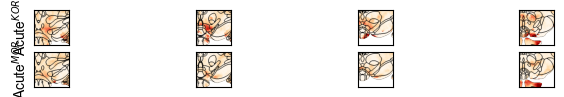

In [163]:
# plot the spatial distribution of cells using betacoef
channel_key = 'overlap'
vmax = 0.3
fig, axs = plt.subplots(len(genotypes), len(z_unique[::5]), 
                        figsize=(len(z_unique[::5])*2, len(Conditions)), sharex=True,sharey = True)

for cidx, genotype in enumerate(genotypes):
    #theatmap = np.load(os.path.join(analysis_resultpath,f'{channel_key}_{condition}_betas.npy'))
    #theatmap = tifffile.imread(os.path.join(analysis_resultpath,f'{genotype}_{channel}_mean_heatmap.tif'))
    theatmap = [genotype1_mean_normalized_heatmap,genotype2_mean_normalized_heatmap][cidx]

    for idx, curated_zplane in enumerate(z_unique[::5]):
        ax = axs[cidx, idx]
        image_slice = theatmap[curated_zplane,imy_slice,imx_slice]
        contour_slice = contour_img[curated_zplane,imy_slice,imx_slice]
        __,overlayed_image = overlap_contour(image_slice,contour_slice,\
        cmin =  0, cmax = vmax,\
        colormap = plt.cm.OrRd,)
        trans_img = set_transparency(overlayed_image[:,:], (atlas_img==0)[curated_zplane,imy_slice,imx_slice])
        ax.imshow(trans_img)

        ax.set_xticks([])  # Remove x ticks
        ax.set_yticks([])  # Remove y ticks
        #ax.axis('off')
        if idx == 0:
            ax.set_ylabel(genotype_names[cidx], color='black', )
        else:
            ax.set_ylabel('', color='black',)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 1024)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 1024)

In [164]:
# calculate the spatial distribution of tdTomato+ cells for each subject
tdTomato_spatial_cell_count_for_subregion = np.array([[[np.nanmean(subset_heatmap[z,np.where(atlas_img[z,:,:] == target_site_subid)[0],\
                                                                         np.where(atlas_img[z,:,:] == target_site_subid)[1]]) for z in z_unique]\
                                                                              for target_site_subid in target_site_subids] \
                                                                                for subset_heatmap in [genotype1_mean_tdT_heatmap,genotype2_mean_tdT_heatmap]])


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_40128\1571715533.py:2: RuntimeWarning: Mean of empty slice
  tdTomato_spatial_cell_count_for_subregion = np.array([[[np.nanmean(subset_heatmap[z,np.where(atlas_img[z,:,:] == target_site_subid)[0],\


In [165]:
# calculate cell count for full region
tdTomato_spatial_cell_count_for_full = np.nansum(tdTomato_spatial_cell_count_for_subregion,axis = 1)

In [166]:
np.save(os.path.join(analysis_resultpath,f'tdTomato_spatial_factors_for_subregion_sum_{target_site_acronym}.npy'),tdTomato_spatial_cell_count_for_full,)
np.save(os.path.join(analysis_resultpath,f'tdTomato_spatial_factors_for_subregion_{target_site_acronym}.npy'),tdTomato_spatial_cell_count_for_subregion,)

In [167]:
# split the Acumbens into anterior middle posterior
z_anterior,z_medial,z_posterior = np.array_split(z_unique, 3)

In [168]:
pannel_key = 'K_tdT'

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


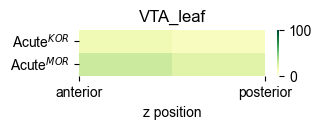

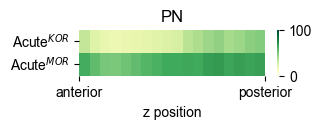

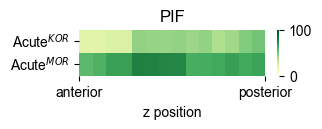

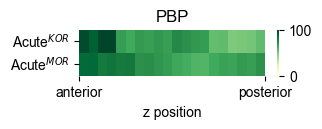

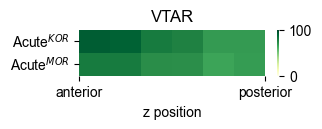

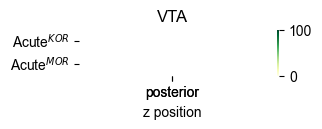

In [169]:
tdTomato_vmax = 100
for  idx,sub_acronym in enumerate(target_site_subacronyms):
    genotype_orders = [np.where(np.array([genotype1,genotype2]) == f)[0][0] for f in genotypes]
    #tarray = spatial_cell_count_for_subregion[rejected_factor_idx,idx,:]
    tarray = tdTomato_spatial_cell_count_for_subregion[genotype_orders,idx,:]
    tarray = tarray[:,~np.isnan(tarray[0,:])]


    fig,axs = plt.subplots(1,1,figsize = (3,0.6))
    sns.heatmap(tarray,ax = axs,cmap = 'YlGn',vmin = 0,vmax= tdTomato_vmax)
    axs.set_title(sub_acronym)
    axs.set_yticks(np.array(range(len(genotype_orders))) + 0.5)
    axs.set_yticklabels(genotype_names,rotation = 0)
    axs.set_xticks([0,tarray.shape[1]])
    axs.set_xticklabels(['anterior','posterior'])    
    
    axs.set_xlabel('z position')
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{sub_acronym}.png'),bbox_inches='tight',dpi = 512)
    fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}_{sub_acronym}.pdf'),bbox_inches='tight',dpi = 512)



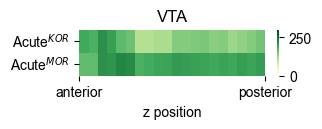

In [170]:
genotype_orders = [np.where(np.array([genotype1,genotype2]) == f)[0][0] for f in genotypes]
#tarray = spatial_cell_count_for_subregion[rejected_factor_idx,idx,:]
tarray = tdTomato_spatial_cell_count_for_full[genotype_orders,:]
tarray = tarray[:,~np.isnan(tarray[0,:])]


fig,axs = plt.subplots(1,1,figsize = (3,0.6))
sns.heatmap(tarray,ax = axs,cmap = 'YlGn',vmin = 0,vmax= tdTomato_vmax*3)
axs.set_title(sub_acronym)
axs.set_yticks(np.array(range(len(genotype_orders))) + 0.5)
axs.set_yticklabels(genotype_names,rotation = 0)
axs.set_xticks([0,tarray.shape[1]])
axs.set_xticklabels(['anterior','posterior'])    

axs.set_xlabel('z position')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 512)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 512)



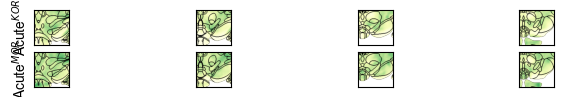

In [172]:
# plot the spatial distribution of cells using betacoef
#channel_key = 'overlap'
vmax = 250
pannel_key = 'Y_tdT'
channel_key = 'Ex_561_Ch1_stitched'
fig, axs = plt.subplots(len(genotypes), len(z_unique[::5]), 
                        figsize=(len(z_unique[::5])*2, len(Conditions)), sharex=True,sharey = True)

for cidx, genotype in enumerate(genotypes):
    #theatmap = np.load(os.path.join(analysis_resultpath,f'{channel_key}_{condition}_betas.npy'))
    #theatmap = tifffile.imread(os.path.join(analysis_resultpath,f'{genotype}_{channel}_mean_heatmap.tif'))
    theatmap = [genotype1_mean_tdT_heatmap,genotype2_mean_tdT_heatmap][cidx]

    for idx, curated_zplane in enumerate(z_unique[::5]):
        ax = axs[cidx, idx]
        image_slice = theatmap[curated_zplane,imy_slice,imx_slice]
        contour_slice = contour_img[curated_zplane,imy_slice,imx_slice]
        __,overlayed_image = overlap_contour(image_slice,contour_slice,\
        cmin =  0, cmax = vmax,\
        colormap = plt.cm.YlGn,)
        trans_img = set_transparency(overlayed_image[:,:], (atlas_img==0)[curated_zplane,imy_slice,imx_slice])
        ax.imshow(trans_img)

        ax.set_xticks([])  # Remove x ticks
        ax.set_yticks([])  # Remove y ticks
        #ax.axis('off')
        if idx == 0:
            ax.set_ylabel(genotype_names[cidx], color='black', )
        else:
            ax.set_ylabel('', color='black',)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches='tight',dpi = 1024)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches='tight',dpi = 1024)

# Correlation analysis

In [135]:
# read the results from the treeFDR f
TreeFDRF_df = pd.read_csv(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\result",\
    'TreeFDRF_pvalue_Figure2_C_glm_stat_df_no_batch.csv'),index_col = False)

In [ ]:
# get the rejected acronyms
rejected_acronyms = TreeFDRF_df[(TreeFDRF_df.acronym.isin(curated_acronyms)) & (TreeFDRF_df.rejected == True)].acronym.values 
print(len(rejected_acronyms)," rejected acronyms")
print(rejected_acronyms)


85  rejected acronyms
['FrA' 'M1' 'M2' 'S1' 'S2' 'A24a (IL)' 'DI' 'GI' 'AuD' 'Au1' 'AuV' 'V2L'
 'V2M' 'V1' 'A24 (Cg)' 'A32 (PrL)' 'O' 'AI' 'A29-30 (RS)' 'PtA' 'TeA '
 'PRh' 'Ect' 'AO' 'TT' 'A25 (DP)' 'CA2' 'CA3' 'DLEnt' 'DIEnt' 'VIEnt'
 'MEnt' 'Post' 'PsS' 'DS' 'VeS' 'STr' 'Cl' 'La' 'CPre' 'CPr' 'CPi' 'CPc'
 'AcbC' 'AcbSh' 'IPAC' 'Tu' 'LS' 'Ce' 'ST' 'Sc' 'PIL' 'PP' 'MG' 'Po' 'PLi'
 'SG' 'AM' 'IAM' 'IAD' 'IMD' 'PoMn' 'MD' 'Sub' 'PVT' 'RE' 'Rh' 'CM' 'PC'
 'PrG' 'MBO' 'Com' 'VTA' 'PlPAG' 'MA3' 'PrEW' '4Sh' 'Pa4' 'VTg' 'SNC'
 'SPTg' 'IP' 'RLi ' 'CLi' 'DR']


In [106]:
data_columns = ['Ex_561_Ch1_stitched_newcounts', 'Ex_561_Ch1_stitched_density', 
        'Ex_639_Ch2_stitched_newcounts',
       'Ex_639_Ch2_stitched_density', 'overlap_strict_counts',
       'overlap_strict_newcounts', 'overlap_strict_density',
       'overlap_over_Ex_561_Ch1_stitched', 'overlap_over_Ex_639_Ch2_stitched',
       'F1_Score']

In [107]:
average_df = total_df[['Genotype','acronym'] + data_columns].groupby(['Genotype','acronym']).mean().reset_index()

In [118]:
subtract_df = (average_df[average_df.Genotype=='KOR-Cre'].set_index('acronym').drop(columns = ['Genotype']) - average_df[average_df.Genotype=='MOR-Cre'].set_index('acronym').drop(columns = ['Genotype']))/(average_df[average_df.Genotype=='KOR-Cre'].set_index('acronym').drop(columns = ['Genotype']) + average_df[average_df.Genotype=='MOR-Cre'].set_index('acronym').drop(columns = ['Genotype']))

In [139]:
tdf = subtract_df.loc[acute_rejected_acronyms,:]

Text(0.5, 0, 'relative tdTomato+ cell density (log)')

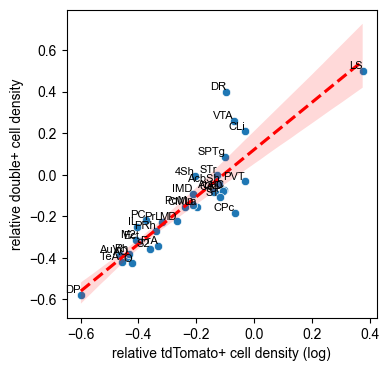

In [140]:
variable1 = 'Ex_561_Ch1_stitched_newcounts'
variable2 = 'overlap_strict_density'

from statannotations.Annotator import Annotator
fig,axs = plt.subplots(1,1,figsize = (4,4,))
sns.scatterplot(data = tdf, x = variable1, y = variable2, ax = axs)
# draw a linear regression line
sns.regplot(data = tdf, x = variable1, y = variable2, ax = axs, scatter=False, color='red', line_kws={'linestyle': '--'})

# make the x axis logarithmic
#axs.set_xscale('log')
# annotate the points with the index of tdf
for i, (idx, row) in enumerate(tdf.iterrows()):
    # get cleaned_acronym column value in the atlas_df using idx
    cleaned_acronym = atlas_df[atlas_df.acronym == idx]['cleaned_acronym'].values[0]
    axs.annotate(cleaned_acronym, (row[variable1], row[variable2]), fontsize=8, ha='right', va='bottom')

axs.set_ylabel('relative double+ cell density')
axs.set_xlabel('relative tdTomato+ cell density (log)')